# Homework 3

## FINM 36700 - 2023

### UChicago Financial Mathematics

* Younghun Lee
* hun@uchicago.edu

## Barnstable

---

In [40]:
import os
import pandas as pd
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt


In [41]:
data = pd.read_excel('./data/spy_data.xlsx', sheet_name = 'total returns').set_index('date').fillna(method = 'ffill')
data['excess_returns'] = data['SPY'] - data['^IRX'] 
data = data['excess_returns']
start = '2000-12-29'
quantile = 0.05
window = 60
data = data.loc[(data.index >= start)]
rets = data.copy() 
rets

date
2000-12-29   -0.019157
2001-01-02   -0.018329
2001-01-03    0.047815
2001-01-04   -0.010972
2001-01-05   -0.032840
                ...   
2024-07-29    0.000384
2024-07-30   -0.005270
2024-07-31    0.016051
2024-08-01   -0.014364
2024-08-02   -0.018818
Name: excess_returns, Length: 5928, dtype: float64

## 1. Modeling Volatility and VaR

### 1.1 Historic VaR.
Starting at t = 61, calculate the historic-based VaR, based on the expanding sample from period 1 (Jan 1926) to $t − 1$. By historic VaR, we mean simply taking the 5th quantile for the historic sample up to time $t − 1$. Of course, a sample size that is not a multiple of 100 will require some interpolation to get a 5th quantile. Your statistical package should handle this fine.

Denote this as $\tilde{r}^{VaR, 0.05}_{t,historic}$ which is the best estimate of the time-t VaR based on data through $t − 1$.

- Plot $\tilde{r}^{VaR, 0.05}_{t,historic}$ over time.


- Calculate the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t,historic}$


- What drawbacks do you see in this historic VaR?

In [42]:
historic_VaR = rets.shift().expanding(min_periods = 60).quantile(.05)
historic_VaR.plot(title = 'Historic VaR', ylabel = 'VaR', xlabel = 'Date')

exceed = sum(rets < historic_VaR)/len(historic_VaR.dropna())
print('5% VaR backtest: {:,.2%}'.format(exceed))

5% VaR backtest: 3.95%


<b> Drawbacks of Historic VaR </b>

1. Backward Looking: Looks at only the historical data while estimating the losses in the future. Availability of sufficient and relevant data becomes a challenge. 


2. Ghosting Effect: Equal Weights on past observations that may never be relevant again. For example, low returns during 2008 (which may not be relevant anymore) are given the same weight as the most recent observations


3. Slow to React: Less Weight on most recent observations. A recent significant loss still does not impact historical VaR because it has the same weight as the other observations

### 1.2 Volatility
We will calculate a time-series of volatility estimates using a few different methods. For each, we use σt to denote our estimate of the time-t return volatility, as based on data over periods 1 (Jan 1926) through $t − 1$, but not including $t$ itself.

- Expanding Series

$$
\sigma^2_{t,expanding} = \frac{1}{t-1}\sum_{\tau = 1}^{t-1}\tilde{r}^2_{\tau}
$$

Begin the calculation at t = 61, so that the first estimate is based on 60 data points.


- Rolling Window

$$
\sigma^2_{t,rolling} = \frac{1}{m}\sum_{l = 1}^{m}\tilde{r}^2_{t-l}
$$

Use m = 60, and begin the calculation at the t = 61, (so that the calculation has a full 60 data points.)


- a. For each of these three methods, plot $\sigma_t$. (Plot the vol, not the variance.)
- b. For each method, calculate the 5th percentile, 1-month-ahead VaR. We use a slight simplification of the normal VaR formula, by dropping µ from that formula, and rounding the normal distribution z-score to -1.65.
$$\tilde{r}^{VaR, 0.05}_{t,vol} = −1.65 \sigma_t$$
- c. For each of these vol-based VaR estimates, calculate the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t,vol}$

- d. Compare and contrast your results among each other and relative to the historic method in the previous problem.

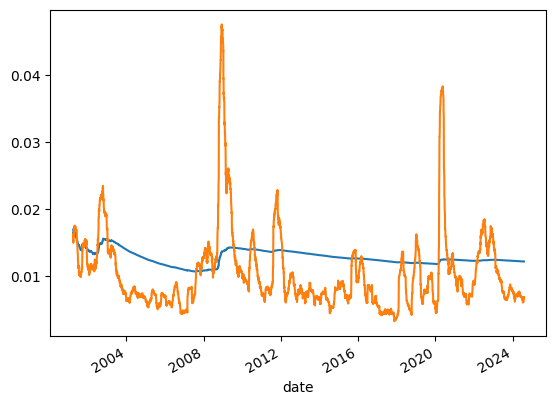

In [60]:
expending_window = np.sqrt((rets**2).expanding(60).mean().shift())
rolling_window = np.sqrt((rets**2).rolling(60).mean().shift())

std = pd.DataFrame({'expanding_window': expending_window, 'rolling_window': rolling_window})
# std.plot(title = 'Volatility Estimate',ylabel = 'Volatility', xlabel = 'Date')
# plt.show()
expending_window.plot()
rolling_window.plot()
plt.show()

In [68]:
VaR

,expanding_window,rolling_window,Historic
date,,,
2000-12-29,NaN,NaN,NaN
2001-01-02,NaN,NaN,NaN
2001-01-03,NaN,NaN,NaN
2001-01-04,NaN,NaN,NaN
2001-01-05,NaN,NaN,NaN
...,...,...,...
2024-07-29,-0.020037,-0.010906,-0.018775
2024-07-30,-0.020036,-0.010882,-0.018775
2024-07-31,-0.020034,-0.010765,-0.018775


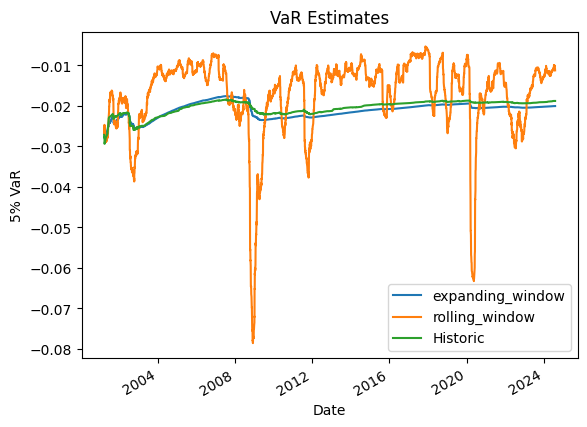

In [59]:
VaR = -1.65 * std
VaR['Historic'] = historic_VaR

VaR.plot(title = 'VaR Estimates', ylabel = '5% VaR', xlabel = 'Date')
plt.show()

In [45]:
# Comparison between two pandas series using apply
# This only works when the index of two series are the same

var_temp = VaR.dropna()
frequency =  var_temp.apply(lambda x: rets.loc[var_temp.index] < x).mean().to_frame('frequency')
frequency.style.format('{:,.2%}')

,frequency
expanding_window,3.65%
rolling_window,6.00%
Historic,3.95%


- Rolling window is a much accurate estimate because it only counts on the most recent observations

### 1.3 CVaR
Re-do the previous two problems, but this time calculating CVaR instead of VaR, (still for q = .05.) That is, calculate CVaR for
    
- the empirical cdf
- the normal model, using expanding volatility estimates
- the normal model, using rolling volatility estimates

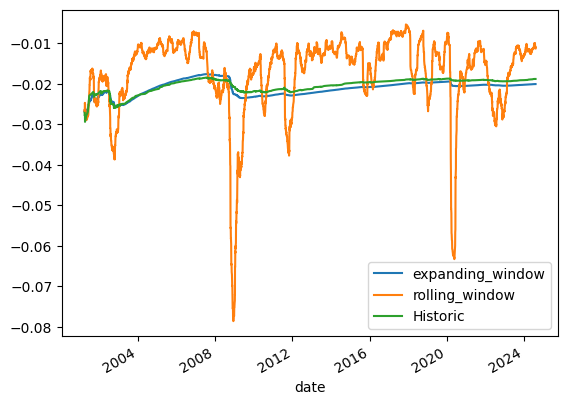

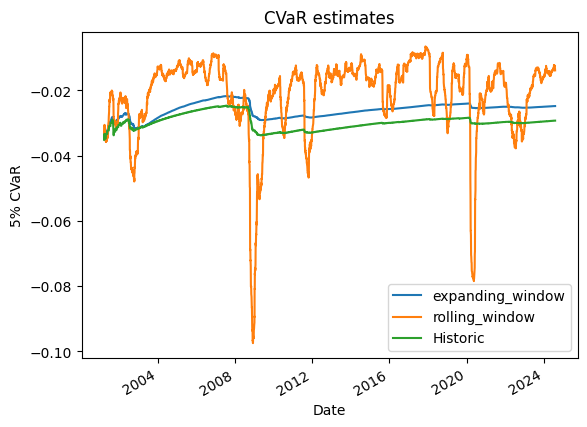

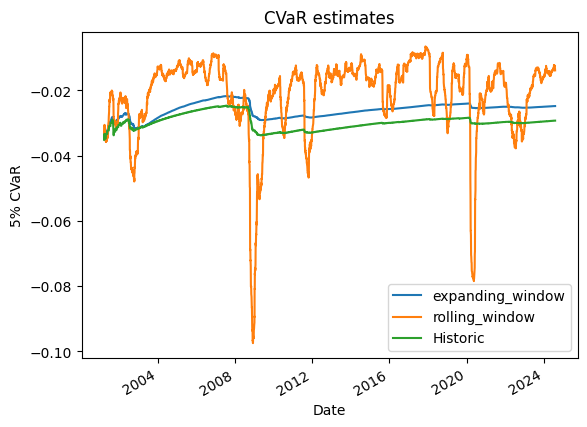

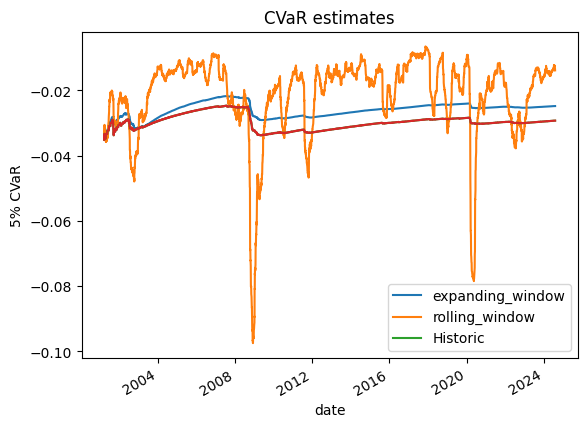

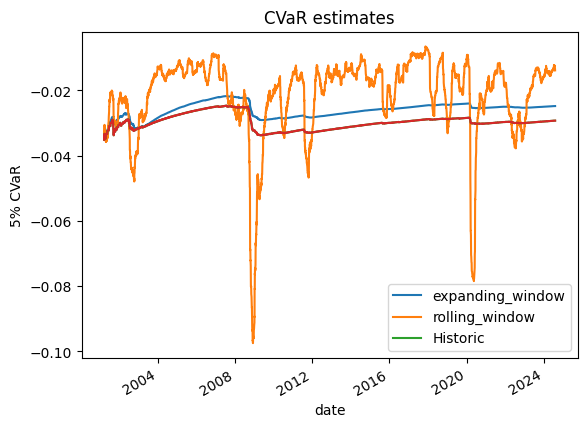

In [72]:
CVaR = -norm.pdf(1.65) / 0.05 * std
CVaR['Historic'] = rets.expanding(60).apply(lambda x: x[x < x.quantile(.05)].mean())
CVaR.plot(title = 'CVaR estimates', ylabel = '5% CVaR', xlabel = 'Date')
CVaR['Historic'].plot()


plt.show()

### 1.4 Extra
We may discuss this after Midterm 1, but it is not part of the Midterm 1 material.

For the VaR calculations of Problem 2.2, and 2.3 try using the following models to estimate volatility:
- <b> Exponentially Weighted Moving Average (EWMA) </b>

    $$
    \sigma^2_{t, EWMA} = \theta \sigma^2_{t-1, EWMA} + (1-\theta)\tilde{r}^2_{t-1}
    $$

    Rather than estimating θ, simply use θ = 0.97, and initialize with σ1 = 0.15.



- <b> GARCH(1,1) model </b>
    To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation implementation is fine. You should be familiar with EWMA and GARCH from the August Review.

In [47]:
from arch import arch_model

GARCH = arch_model(rets, vol='Garch', p=1, o=0, q=1, dist='Normal')
GARCH_model = GARCH.fit()
garch_param = GARCH_model.params

Iteration:      1,   Func. Count:      6,   Neg. LLF: 253167642783.41043
Iteration:      2,   Func. Count:     21,   Neg. LLF: 5.152205964128159e+18
Iteration:      3,   Func. Count:     36,   Neg. LLF: 30992248585137.703
Iteration:      4,   Func. Count:     51,   Neg. LLF: 9.085106625538724e+21
Iteration:      5,   Func. Count:     61,   Neg. LLF: 93014786520.32129
Iteration:      6,   Func. Count:     72,   Neg. LLF: 5949190159905.776
Iteration:      7,   Func. Count:     86,   Neg. LLF: 2968111524396359.0
Iteration:      8,   Func. Count:    101,   Neg. LLF: 132778492718.53699
Iteration:      9,   Func. Count:    113,   Neg. LLF: 705820025.4918808
Iteration:     10,   Func. Count:    126,   Neg. LLF: 1.7523132486481367e+19
Iteration:     11,   Func. Count:    140,   Neg. LLF: 6142.70364232233
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6142.703726028198
            Iterations: 15
            Function evaluations: 140
            Gradien

In [48]:
theta = 0.97
sigma1 = 0.15

avail_dates = std.dropna().index

# initialize the first value
garch = pd.Series(0, index = avail_dates, name = 'GARCH')
garch[0] = sigma1

ewma = pd.Series(0, index = avail_dates, name = 'EWMA')
ewma[0] = sigma1

for i, ind in enumerate(avail_dates[1:], 1):
    ### Forecast variance by plugging the GARCH and IGARCH parameters into their respective equations
    garch[i] = np.sqrt(garch_param['omega'] \
        + garch[i-1]**2 * garch_param['beta[1]'] \
            + rets.loc[ind]**2 * garch_param['alpha[1]'])
    ewma[i] = np.sqrt(ewma[i-1]**2 * theta + (1-theta) * rets.loc[ind]**2)

std = pd.concat([std, garch, ewma], axis = 1)
std.dropna()

,expanding_window,rolling_window,GARCH,EWMA
date,,,,
2001-03-28,0.016083,0.016083,0.150000,0.150000
2001-03-29,0.016343,0.016292,0.140713,0.147734
2001-03-30,0.016217,0.016126,0.132037,0.145512
2001-04-02,0.016140,0.014957,0.124048,0.143361
2001-04-03,0.016238,0.015146,0.116850,0.141314
...,...,...,...,...
2024-07-29,0.012144,0.006610,0.009937,0.007385
2024-07-30,0.012143,0.006595,0.009625,0.007330
2024-07-31,0.012142,0.006524,0.010502,0.007736


In [49]:
VaR = -1.65*std
VaR['Historic'] = historic_VaR

VaR.plot(title = 'VaR Estimates', ylabel = '5% VaR', xlabel = 'Date')

<Axes: title={'center': 'VaR Estimates'}, xlabel='Date', ylabel='5% VaR'>

In [50]:
var_temp = VaR.dropna()
frequency =  var_temp.apply(lambda x: rets[var_temp.index] < x).mean(numeric_only=True).to_frame('frequency')
frequency.style.format('{:,.2%}')

,frequency
expanding_window,3.65%
rolling_window,6.00%
GARCH,3.68%
EWMA,4.96%
Historic,3.95%


## 2. Barnstable’s Analysis

### 2.1 Barnstable's Philosophy

(a) What has Barnstable’s investment strategy been in the past?

- Barnstable focused on equities, primarily U.S. equities, rather than other safer assets.

(b) Explain the logic behind their view that stocks are safer in the long run.

- The risk of holding stocks dimishes as the holding period increases. This is because the law of large numbers will apply to the long-run returns and the annualized average (log) return will converge to the population mean. 
- Thus, if the population mean of equities is higher than other asset classes, the h-period return is almost certainly larger for equities as gets large.

(c) What assumptions underly Barnstable’s belief in the long-run safety of stocks?

- It assumes the uncorrelated movement between the returns of different timesteps. It uses  indepedant, identical distribution (i.i.d) assumption to calculate the long-run return.

### 2.2 Two Proposals

(a) Describe the two proposals Barnstable is considering for how to take advantage of their view regarding the long-run safety of stocks.

1. Selling long horizon **put options** on the S\&P 500.
    - Selling puts generates constant cash flows through the put price, but increases Barnstable's downside risk. Barnstable believes this downside risk is limited in the long-run.
    $$
    \Gamma^{selling puts}_{30} = -max(e^{0.06 * 30} - r^M_{t, t+30}, 0) 
    $$

2. Creat **trust** with assets (stock in S&P500) and liability (Preference Share and Common Shares)
    - Exposure to all the upside of the equity market, but is actually insuring against the downside risk as they simply return the asset if it underperforms the 6% strike growth rate.

(b) How is the trust different from simply shorting the risk-free rate to take a levered position in stocks?

- The trust allows Barnstable to increase their position in the equity market exactly as would be accomplished by borrowing at the risk-free rate and investing it in stocks. But the trust locks the lenders (preferred shares) into a 30-year commitment. This removes Barnstable's liquidity risk, ensuring that they can hold the investment for the long-run.

(c) Do these proposals take the same bet on long-run stock performance? In what outcomes will they have different returns?

- **Common shares** are identical to buying call options on the stock, with a strike price growing at the  benchmark. The payoff at maturity of the common share is

    $$
    \Gamma^{selling puts}_{30} = -max(r^M_{t, t+30} - e^{0.06 * 30}, 0) 
    $$

- **Preference shares** have an exposure identical to being long the cumulative riskless rate of 6% and selling puts on the stock, $r^M_{t, t+30}$. So the payoff is

    $$
    \Gamma^{selling puts}_{30} = e^{0.06 * 30} - max(e^{0.06 * 30} - r^M_{t, t+30}, 0) 
    $$

- One can verify that the payoff of the preferred and common shares indeed sums to the payoff of $r^M_{t, t+30}$.


(d) Do the two proposals differ in their risk?

- The risk profiles are enormously different. As described above, the put strategy means Barnstable has a huge liability with respect to stock under-performance. The trust strategy does not have any liability, as that is born by the preferred shareholders. There is a risk to long-run under-performance, and the trust neutralizes Barnstable from this risk while the put strategy loads into it.

### 2.3 Do you recommend a direct investment in the S\&P, the trust or the puts?

- The trust, it gets rid of Barnstable's liquidity risk when it comes to holding the position, and doesn't have the extreme tail risk that selling the puts does.

## 3. Estimating Underperformance

Use the returns on the S\&P $500\left(r^M\right)$ and 1-month T-bills, $\left(r^f\right)$ provided in "barnstable_analysis_data.xlsx".
Barnstable's estimates of mean and volatility are based on the subsample of 1965 to 1999 . We consider this subsample, as well as 2000-2023, as well as the full sample of 1926-2023. We only have data through August of 2023, but no adjustment is needed for the fact that you have only the partial year-just use what you have.

### 3.1 Summary Statistics
- (a) Report the following (annualized) statistics.

|  |  | $1965-1999$ | $2000-2023$ | $1926-2023$ |
| :---: | :---: | :---: | :---: | :---: |
|  |  | mean vol | mean vol | mean vol |
| levels | $r^M$ |  |  |  |
|  | $\tilde{r}^M$ |  |  |  |
|  | $r^f$ |  |  |  |
| $\log s$ | $\mathrm{r}^M$ |  |  |  |
|  | $\tilde{\mathbf{r}}^M$ |  |  |  |
|  | $\mathrm{r}^f$ |  |  |  |

- (b) Comment on how the full-sample return stats compare to the sub-sample stats. Comment on how the level stats compare to the log stats.

In [51]:
agg_years = [(1965, 1999), (2000, 2023), (1926, 2023)]
def calc_analytics_by_year(data, agg_years):
    res = []
    for y in agg_years:
        sub = data.loc[str(y[0]):str(y[1])]
        res.append({'mean': sub.mean() * 12, 'vol': sub.std() * np.sqrt(12)})
    return pd.DataFrame(res, index = [f'{i[0]} - {i[1]}' for i in agg_years]).stack()

sum_stats = data.apply(calc_analytics_by_year, agg_years = agg_years).T
log_sum_stats = np.log(1 + data).apply(calc_analytics_by_year, agg_years = agg_years).T

res_stats = pd.concat([sum_stats, log_sum_stats])
res_stats.index = pd.MultiIndex.from_product([['levels','logs'], sum_stats.index.to_list()])
res_stats.style.format('{:,.2%}')

AttributeError: 'float' object has no attribute 'loc'

Full sample estimates are significantly different for the excess returns, this is because of the low risk-free rate during that period. The log returns show lower mean returns as expected.

### 3.2 Recall the following...
- If $x \sim \mathcal{N}\left(\mu_x, \sigma_x^2\right)$, then
$$
\begin{aligned}
\operatorname{Pr}[x<\ell] & =\Phi_{\mathcal{N}}(L) \\
L & =\frac{c-\mu_x}{\sigma_x}
\end{aligned}
$$
where $\Phi_{\mathcal{N}}$ denotes the standard normal cdf.
- Remember that cumulative log returns are simply the sum of the single-period log returns,
$$
\mathrm{r}_{t, t+h}^M \equiv \sum_{i=1}^h \mathrm{r}_{t+i}^M
$$
- It will be convenient to use and denote sample averages. We use the following notation for an $h$-period average ending at time $t+h$,
$$
\overline{\mathrm{r}}_{t, t+h}^M=\frac{1}{h} \sum_{i=1}^h \mathrm{r}_{t+i}^M
$$

Calculate the probability that the cumulative market return will fall short of the cumulative risk-free return. ${ }^2$
$$
\operatorname{Pr}\left[R_{t, t+h}^M<R_{t, t+h}^f\right] \qquad...\qquad Equ. (1)
$$

To analyze this analytically, convert the probability statement above to a probability statement about mean log returns.
- (a) Calculate (1) using the subsample 1965-1999.
- (b) Report the precise probability for $h=15$ and $h=30$ years.
- (c) Plot the probability as a function of the investment horizon, $h$, for $0<h \leq 30$ years.

**Note for solving (a):**

$$
\begin{aligned}
\operatorname{Pr}\left[R_{t, t+h}^M<R_{t, t+h}^f\right] &= \operatorname{Pr}\left[\log (R_{t, t+h}^M) - \log (R_{t, t+h}^f) < 0 \right] = \operatorname{Pr}\left[ \mathrm{r}_{t, t+h}^M - \mathrm{r}_{t, t+h}^f < 0 \right] \\
&= \operatorname{Pr}\left[ \sum_{i=t}^{t+h}{\mathrm{r}}_{i}^M - \sum_{i=t}^{t+h}{\mathrm{r}}_{i}^f < 0 \right] = \operatorname{Pr}\left[ \sum_{i=t}^{t+h}(\mathrm{r}_{i}^M - \mathrm{r}_{i}^f) < 0 \right] \\
&= \operatorname{Pr}\left[ \sum_{i=t}^{t+h}\tilde{\mathrm{r}}_{i} < 0 \right] = \operatorname{Pr}\left[ \tilde{\mathrm{r}}_{t, t+h} < 0 \right] \\
\end{aligned}
$$

Let annualized mean and volatility of log excess return as $\mu$ and $\sigma$, then we can see

$$
\tilde{\mathrm{r}}_{t, t+h} \sim \mathcal{N}\left(h\mu, h\sigma^2\right)
$$

As such,

$$
\operatorname{Pr}\left[ \tilde{\mathrm{r}}_{t, t+h} < 0 \right] = 
\operatorname{Pr}\left[ Z < \frac{-h\mu}{\sqrt{h}\sigma} \right] \\
= \Phi_{\mathcal{N}}\left(-\sqrt{h}\frac{\mu}{\sigma}\right)
$$

In [ ]:
def prob(mu, sigma, h):
    return norm.cdf(np.sqrt(h)*mu/sigma)

mu, sigma = res_stats['1965 - 1999'].loc[('logs', 'excess_returns')]

print(f'SPX underperforming RF in the next 15 years after 1999: {prob(mu = -mu, sigma = sigma, h = 15):,.2%}')

print(f'SPX underperforming RF in the next 30 years after 1999: {prob(mu = -mu, sigma = sigma, h = 30):,.2%}')

h = np.arange(30) + 1
probs = pd.DataFrame([prob(-mu, sigma, x) for x in h], columns=['Probability of Underperformance'], index = h)
probs.plot()

### 3.3

Use the sample 1965-2023 to reconsider the 30-year probability. As of the end of 2023, calculate the probability of the stock return underperforming the risk-free rate over the next 30 years. That is, $R_{t, t+h}^M$ underperforming $R_{t, t+h}^f$ for $0<h \leq 30$.

In [ ]:
mu = np.log(1+rets.loc['1965':'2023']).mean() * 12
sigma = np.log(1+rets.loc['1965':'2023']).std() * np.sqrt(12)
h = np.arange(30)+1

probs = pd.DataFrame([prob(mu, sigma, x) for x in h], columns=['Probability of Underperformance'], index = h)
probs.plot(title = 'Sample from 1965 to 2023', ylabel = 'Probability', xlabel = 'h periods')
plt.show()

### 3.4

Let's consider how things turned out relative to Barnstable's 1999 expectations.
- (a) What was the probability (based on the 1999 estimate of $\mu$,) that the 23-year market return, $R_{t, t+23}^M$, would be smaller than that realized in 2000-2023? Note that we are asking about the market return, not the excess market return. Continue using the 1965-1999 sample standard deviation for $\sigma$.
- (b) Suppose Barnstable had implemented the put-option strategy with the growing strike of $6 \%$ ? Based on the 2000-2023 performance, what is the probability that the 2000-2029 cumulative market return will be low enough to make the puts in the money? For the calculation, update your estimates of $\mu, \sigma$ to be the estimates based on 1965-2023.

In [ ]:
mu = res_stats[('1965 - 1999', 'mean')].loc[('logs', 'SPX')] - res_stats[('2000 - 2023', 'mean')].loc[('logs', 'SPX')]
sigma = res_stats[('1965 - 1999', 'vol')].loc[('logs', 'SPX')]

print(f"Probability of underperformance in 2000-2023: {prob(-mu, sigma, 24):,.2%}")

**Note for solving (b):**

For next 6 years (2024 ~ 2029), calculate the probability of the cummulative market return being lower than the strike grows of the put option.

$$P\left(\Pi_{t=2000}^{2029} (1+r_t^M) < 1.06^{30}\right)$$


- log-growth of put strike as $\mathrm{r}_G = \log(1.06)$.
- We know $\mu$ and $\sigma$ of $\mathrm{r}^M$ from 1965 - 2023
- We know the performance during 2000 - 2023. 
  - Let the mean of the log return during 2000 - 2023 as $\mu_{perf} = \frac{1}{24}\sum_{t=2000}^{2023}\mathrm{r}_t^M = \frac{1}{24}\mathrm{r}_{2000, 2023}^M$

What we want to calculate is

$$
\begin{aligned}
P(\mathrm{r}_{2000, 2029}^M < 30\mathrm{r}_G)
&= P(\mathrm{r}_{2000, 2023}^M + \mathrm{r}_{2024, 2029}^M < 30\mathrm{r}_G)\\
&= P(\mathrm{r}_{2024, 2029}^M < 30\mathrm{r}_G - \mathrm{r}_{2000, 2023}^M)\\
&= P(\mathrm{r}_{2024, 2029}^M < 30\mathrm{r}_G - 24\mu_{perf})\\
&= P(\mathrm{r}_{2024, 2029}^M < 24(\mathrm{r}_G - \mu_{perf}) + 6\mathrm{r}_G)\\
&= P(1/6 \times \mathrm{r}_{2024, 2029}^M < \frac{24}{6}(\mathrm{r}_G - \mu_{perf}) + \mathrm{r}_G)\\
&= P(\bar{\mathrm{r}}^M < \frac{24}{6}(\mathrm{r}_G - \mu_{perf}) + \mathrm{r}_G)\\
\end{aligned}
$$

Using annualized log return $\mathrm{r}^M \sim \mathcal{N}(\mu, \sigma^2)$ and $\mathrm{r}_{2024, 2029}^M \sim \mathcal{N}(6\mu, 6\sigma^2)$,

$$\bar{\mathrm{r}}^M \sim \mathcal{N}\left(\mu, \frac{1}{6}\sigma^2\right)$$

So, we can calculate the probability as

$$
P(\bar{\mathrm{r}}^M < \frac{24}{6}(\mathrm{r}_G - \mu_{perf}) + \mathrm{r}_G) = \Phi_{\mathcal{N}}\left( -\frac{\frac{24}{6}(\mu_{perf} - \mathrm{r}_G) +  \mu- \mathrm{r}_G}{\sigma/\sqrt{6}}\right)
$$

We can also decompose the target as two part
- $\frac{24}{6}(\mu_{perf} - \mathrm{r}_G)$ : How much we have been over-performing relative to the strike growth
- $\mu - \mathrm{r}_G$ : How much we need to perform relative to the strike growth

In [ ]:
strike = np.log(1.06)
mean_return = np.log(1+data['SPX'].loc['1965':]).mean() * 12
sigma = np.log(1 + data['SPX'].loc['1965':]).std() * np.sqrt(12)
performance = np.log(1+data['SPX'].loc['2000':]).mean() * 12
mu = 24/6 * (strike - performance) + strike - mean_return

print(f'Probability of Puts ending in the money: {prob(mu, sigma, 6):,.2%}')